In the last few days I came across [this](https://codegolf.stackexchange.com/questions/50299/draw-an-image-as-a-voronoi-map) stack exchange code-golf challenge about reducing a photo to a set of polygons using a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). I'm going to have a go, but I'm going to change the goal a bit. Rather then creating polygons, I'm going to use a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) to turn an image into a set of triangles. 

My reason for approaching the problem like this is that Voronoi maps create polygons which are centered around points. In a triangulation, the points are the vertices. This means that if we can identify the points of an image which match the natural boundaries, the vertices of our triangulation should follow them. The question is how we identify what constitutes an "interesting" point.

Before we get into that, some notes on:
 - A *Triangulation* of a set of points is a way of covering the convex hull defined by the points with triangles (or simplices in higher dimensions) such that the points are the vertices of the triangles and any two triangles either share a complete edge, or do not intersect at all.
 - There are many ways a set of points can be split into a triangulation
 - The Delaunay triangulation is defined as a triangulation such that each [circumcircle](https://en.wikipedia.org/wiki/Circumscribed_circle#Triangles) of the triangles does not contain any points. This has the property that is maximises the minimum angle - making the triangles appear even and not unnecessarily sharp. It is this property that makes it appealing to use for subdividing an image.
 
The notes [here](http://www.cs.uu.nl/docs/vakken/ga/slides9alt.pdf) have a good discussion of Delaunay triangulation and how it is calculated. We will be using the [scipy implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.Delaunay.html).

As with my [previous post on image processing](http://www.degeneratestate.org/posts/2016/Oct/23/image-processing-with-numpy/), I'm going to use the following image 

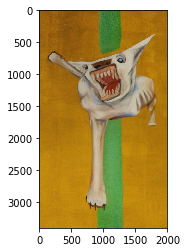

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial import Delaunay

%matplotlib inline
%load_ext autoreload
%autoreload 2

im = plt.imread("BTD.jpg")
im = im[400:3800,:2000,:]    
plt.imshow(im)

# Uniform Random Points

Let's start with the simplest approach. We will generate $N$ points uniformly over the image and look at the resulting patterns formed by applying the triangulation.

Most of the code here is wrapped up in a utility module "triangulared". The full code for both this module, and the notebook that produces this post can be found [here](https://github.com/ijmbarr/images-to-triangles). 

It applies the following steps:
 - Generate a set of points for an image
 - Generates the triangulation of these points
 - Replaces the image with a set of triangles coloured with the median value of the pixels they cover
 
The results are below

In [2]:
from triangulared import *

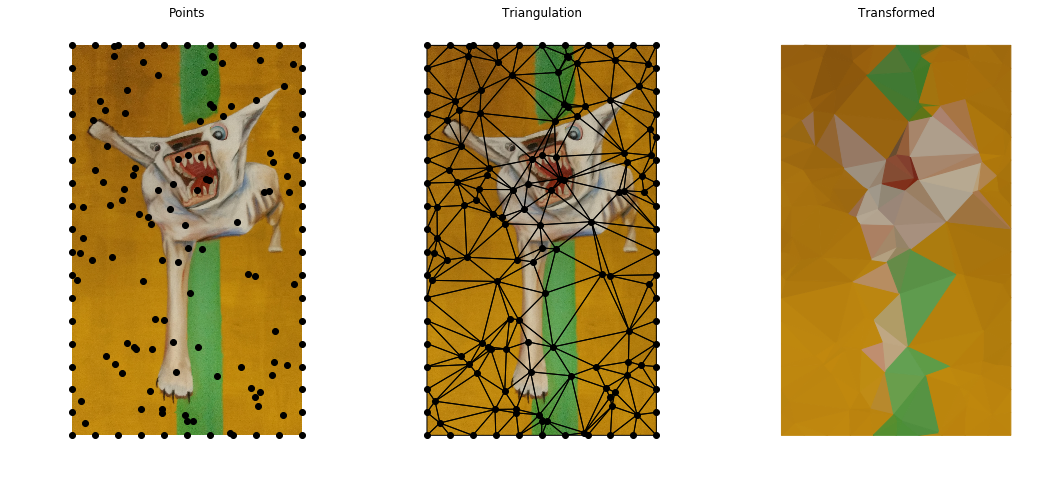

In [3]:
points = generate_uniform_random_points(im, n_points=100)
tri = Delaunay(points)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, im)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, im)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, im)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)


If we know the original image, we might be able to guess what the transformed image is, but it is not clear. Things get a bit better when we increase the number of points: 

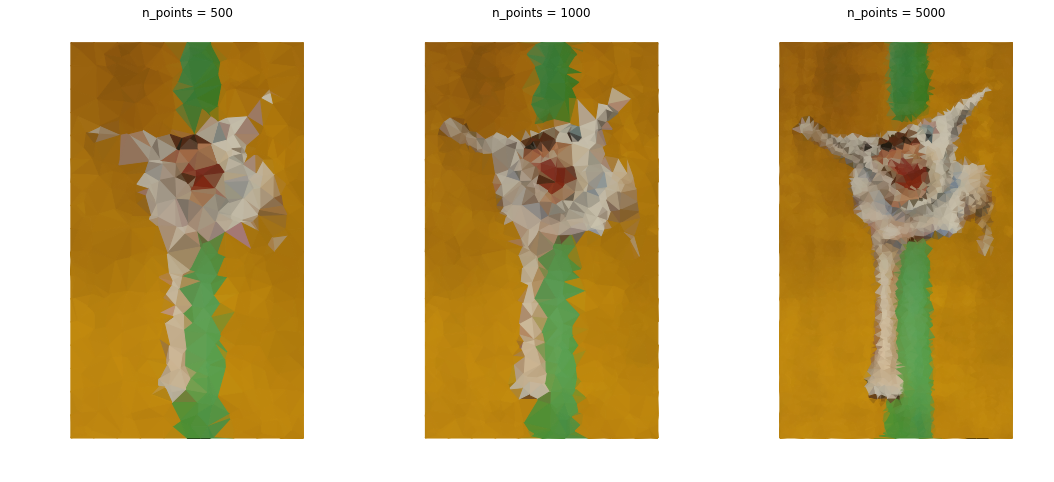

In [4]:
fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

for ax, n_points in zip(axs, [500,1000,5000]):
    points = generate_uniform_random_points(im, n_points=n_points)
    tri = Delaunay(points)
    ax.invert_yaxis()
    triangle_colours = get_triangle_colour(tri, im)
    draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
    ax.set_title("n_points = {}".format(n_points))
    set_axis_defaults(ax)


But it feels like we should be able to do better. There are large areas of the image where the colour doesn't change much, and when we choose our points at random these areas get just as high a density of points as any other area. Maybe if we can choose points based on how much things change, we can represent the image faithfully with fewer points. 

# Maximum Entropy Points
There are lots of ways we can define "interesting" points, but a good starting point is to choose points which have high [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory). Entropy, in information theory, is a measure of how "random" a probability distribution is. 

To define the entropy of a pixel in an image, we look at a small neighbourhood surrounding it. We treat the values of the pixels in this neighbourhood as a probability distribution and measure its Shannon entropy.

[Scikit Image](http://scikit-image.org/) has a nice function which does all of this for us. Let's see how it looks:

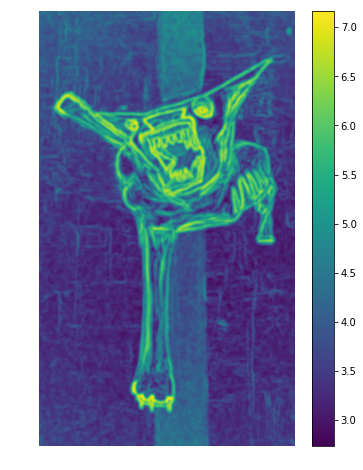

In [5]:
from skimage import filters, morphology, color

entropy_width = 20

# convert to grayscale
im2 = (255 * color.rgb2gray(im)).astype("uint8")

# calculate entropy
im2 = filters.rank.entropy(im2, morphology.disk(entropy_width))

# plot it
fig, ax = plt.subplots(figsize=(6,8), sharey=True)
cax = ax.imshow(im2)
set_axis_defaults(ax)
fig.colorbar(cax);

We now have a measure of how "interesting" each point is. The next step is to find a way to choose $N$ points from the pixels. If we choose the top $N$ points ranked by pixel value, we would end up with lots of points clumped together. To get around this, we need a way to penalise choosing a point too close to an existing point. I achieve this by lowering the entropy of the image around the chosen pixel after each choice. 

The steps are now:
 - select top pixel by entropy
 - subtract a Gaussian blur from the image, centred on the selected point
 - repeat until we have $N$ points
 
The results are

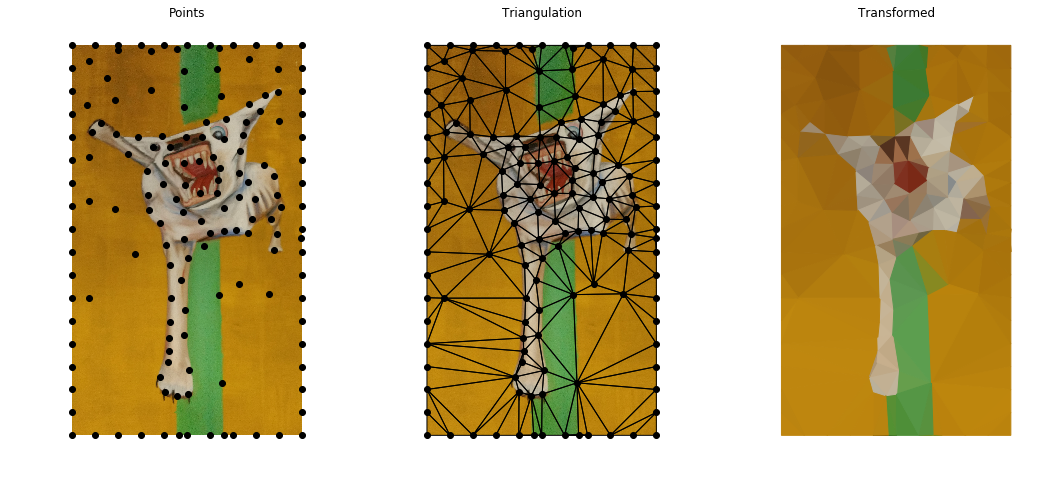

In [6]:
points = generate_max_entropy_points(im)
points = np.concatenate([points, edge_points(im)])

tri = Delaunay(points)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, im)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, im)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, im)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)

It works surprisingly well.

The whole process is wrapped up in a function in my triangulared module. 

To check how well this process generalises I have taken a few public domain photos from [pexels.com](http://www.pexels.com) and applied the process. The results are below

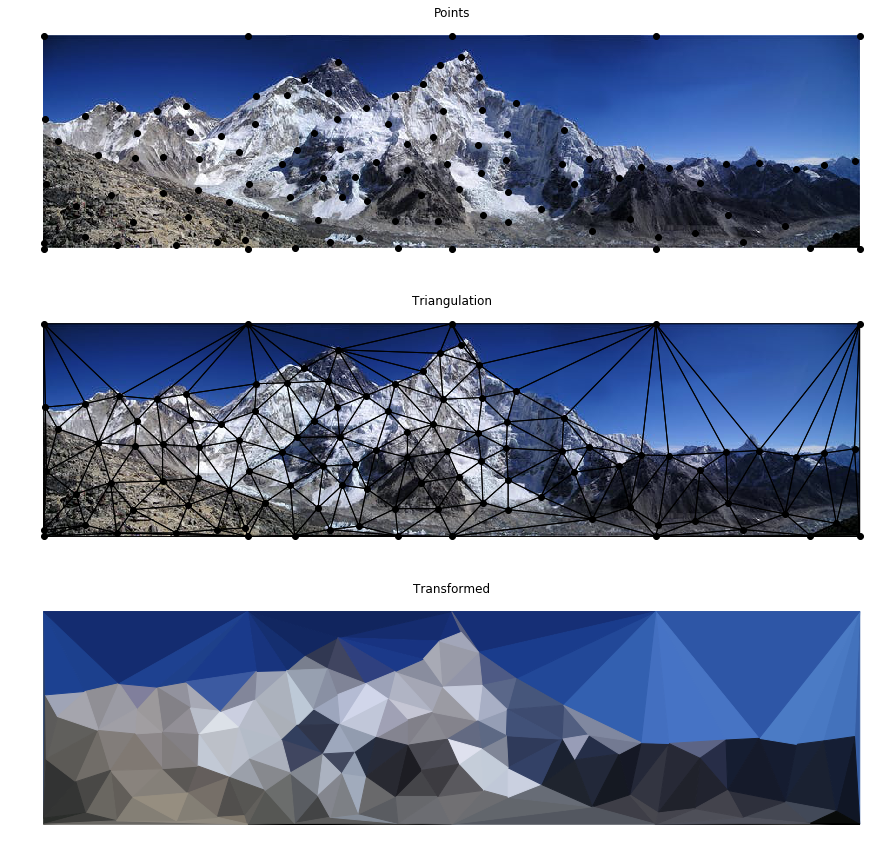

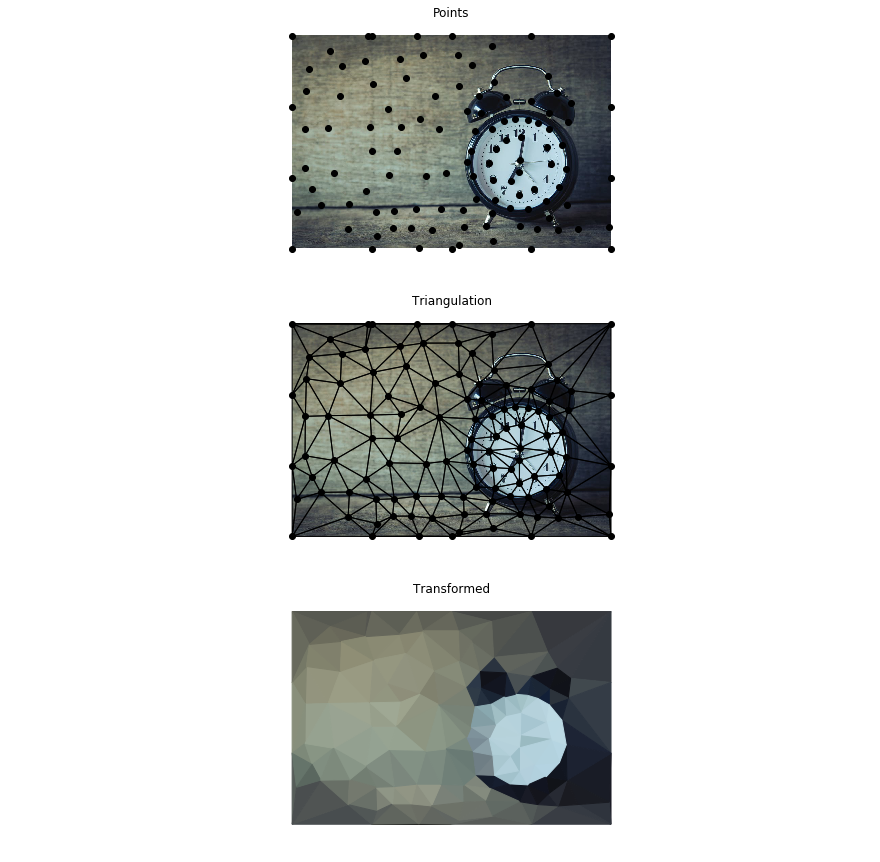

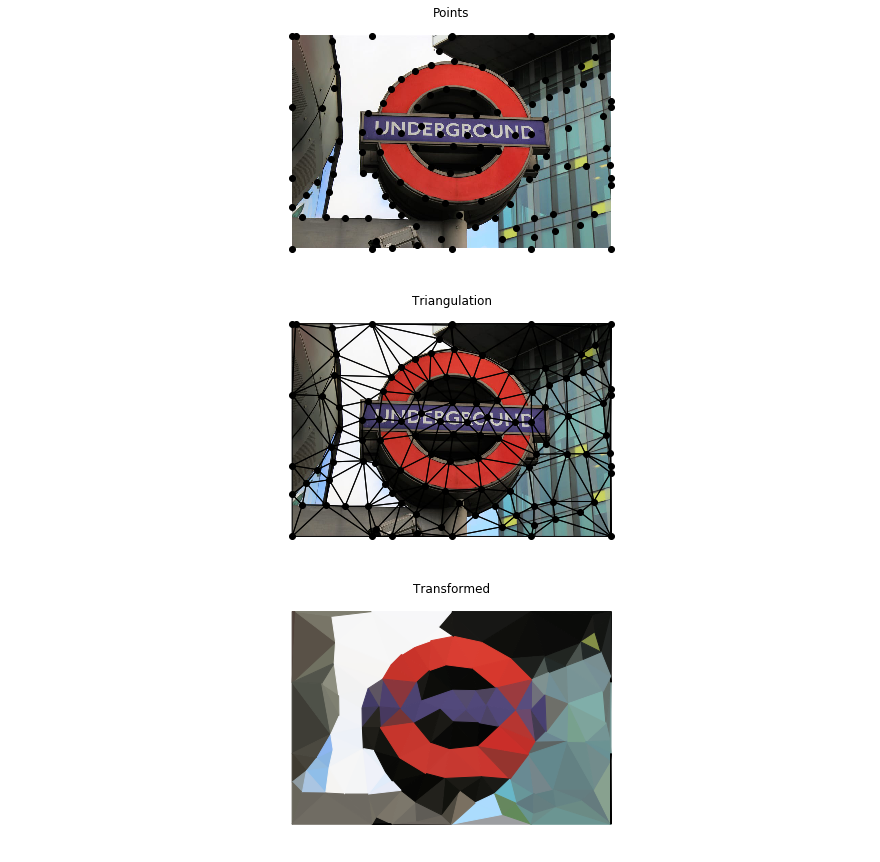

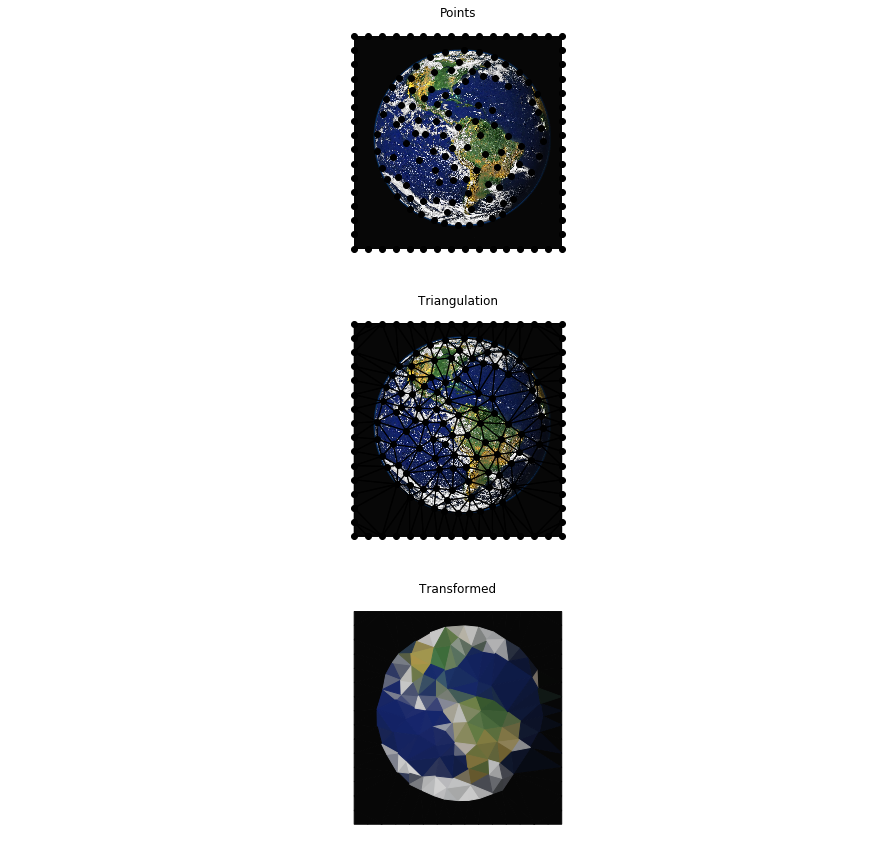

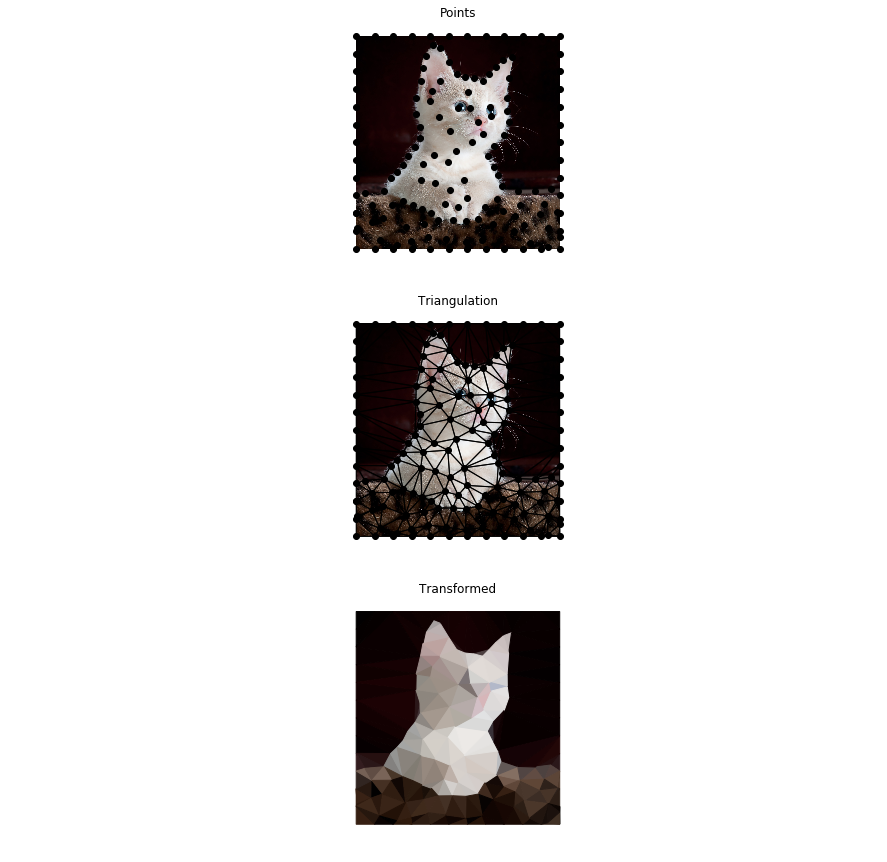

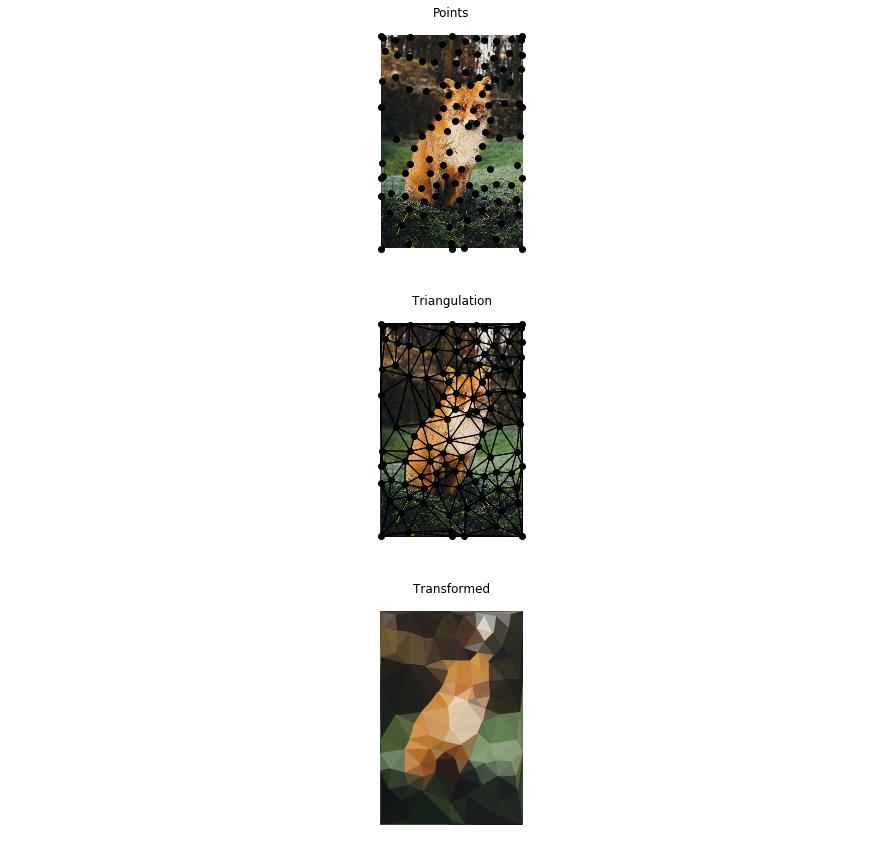

In [7]:
import glob

photo_files = glob.glob("test-images/*")

t = photo_files[1]

current_im = plt.imread(t)

for ci in photo_files:

    current_im = plt.imread(ci)

    current_points = generate_max_entropy_points(current_im)
    current_points = np.concatenate([current_points, edge_points(current_im)])
    tri = Delaunay(current_points)

    fig, axs = plt.subplots(nrows=3, figsize=(15,15), sharey=True)

    ax = axs[0]
    draw_image(ax, current_im)
    draw_points(ax, current_points)
    ax.set_title("Points")
    set_axis_defaults(ax)


    ax = axs[1]
    draw_image(ax, current_im)
    draw_points(ax, current_points)
    draw_triangles(ax, tri.points, tri.vertices)
    ax.set_title("Triangulation")
    set_axis_defaults(ax)


    ax = axs[2]
    triangle_colours = get_triangle_colour(tri, current_im, agg_func=np.median)
    draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
    ax.set_title("Transformed")
    set_axis_defaults(ax)


I'm happy with the results. It might not be the most efficient process, but it works.

To make this usable, the whole process is wrapped in a script `triangleit.py` which can be used as 

```
triangleit.py path/to/image path/to/outout -n number_of_points
```

# Conclusion

That's all for now. The full code for this is available on github [here](https://github.com/ijmbarr/images-to-triangles)